# Model Training, Experiment Tracking, Model Selection and Save Predictions

### Install imblearn library for handling imbalanced class problem

In [1]:
%pip install imblearn

StatementMeta(, a4f4b4b4-a1ed-4a09-a7f4-3c7ee851591b, 7, Finished, Available, Finished)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 238.4/238.4 kB 14.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.5/13.5 MB 165.4 MB/s eta 0:00:0000:010:01
  Attempting uninstall: threadpoolctl
    Found existing installation: threadpoolctl 2.2.0
    Not uninstalling threadpoolctl at /home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages, outside environment /nfs4/pyenv-780d3588-5e8c-47ec-b0ef-bef9430e3d00
    Can't uninstall 'threadpoolctl'. No files were found to uninstall.
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.2.2
    Not uninstalling scikit-learn at /home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages, outside environment /nfs4/pyenv-780d3588-5e8c-47ec-b0ef-bef9430e3d00
    Can't uninstall 'scikit-learn'. No files were found to uninstall.

[notice] A new release of pip is available: 24.0 -> 25.0.1
[notice] To update, run: python -m pip install --upgrade pip
Note: you may

### Setup MLFlow Experiment to track and register model

In [3]:
# Create Experiment to Track and register model with mlflow
import mlflow
print(f"mlflow library version: {mlflow.__version__}")
EXPERIMENT_NAME = "customer_churn_prediction_demo"
mlflow.set_experiment(EXPERIMENT_NAME)

StatementMeta(, a4f4b4b4-a1ed-4a09-a7f4-3c7ee851591b, 10, Finished, Available, Finished)

2025/04/22 16:23:19 INFO mlflow.tracking.fluent: Experiment with name 'customer_churn_prediction_demo' does not exist. Creating a new experiment.


mlflow library version: 2.12.2


<Experiment: artifact_location='', creation_time=1745339000992, experiment_id='dac4cd46-6593-4531-bda2-45e80cfa997e', last_update_time=None, lifecycle_stage='active', name='customer_churn_prediction_demo', tags={}>

### Load the data

In [4]:
churn_feat_ready_df = spark.read.format("delta").load("Tables/churn_feat_ready").toPandas()

StatementMeta(, a4f4b4b4-a1ed-4a09-a7f4-3c7ee851591b, 11, Finished, Available, Finished)

### Enable MLFLow AutoLogging

In [5]:
mlflow.set_experiment(EXPERIMENT_NAME) # Use date stamp to append to experiment
mlflow.autolog(exclusive=False)

StatementMeta(, a4f4b4b4-a1ed-4a09-a7f4-3c7ee851591b, 12, Finished, Available, Finished)

### Import the required libraries for model training

In [6]:
# Import the required libraries for model training and evaluation
from sklearn.model_selection import train_test_split
from lightgbm import LGBMClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, precision_score, confusion_matrix, recall_score, roc_auc_score, classification_report

StatementMeta(, a4f4b4b4-a1ed-4a09-a7f4-3c7ee851591b, 13, Finished, Available, Finished)

2025/04/22 16:24:15 WARNING mlflow.utils.autologging_utils: You are using an unsupported version of sklearn. If you encounter errors during autologging, try upgrading / downgrading sklearn to a supported version, or try upgrading MLflow.
2025/04/22 16:24:16 INFO mlflow.tracking.fluent: Autologging successfully enabled for sklearn.
2025/04/22 16:24:22 INFO mlflow.tracking.fluent: Autologging successfully enabled for lightgbm.


### Prepare training and test datasets

In [7]:
SEED = 42
y = churn_feat_ready_df["Exited"]
X = churn_feat_ready_df.drop("Exited", axis=1)
# Train-Test Separation
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=SEED)

print(f"train set count:{X_train.count()}")
print(f"test set count:{X_test.count()}")

StatementMeta(, a4f4b4b4-a1ed-4a09-a7f4-3c7ee851591b, 14, Finished, Available, Finished)

train set count:CreditScore          7500
Age                  7500
Tenure               7500
Balance              7500
NumOfProducts        7500
HasCrCard            7500
IsActiveMember       7500
EstimatedSalary      7500
NewTenure            7500
NewCreditsScore      7500
NewAgeScore          7500
NewBalanceScore      7500
NewEstSalaryScore    7500
Geography_France     7500
Geography_Germany    7500
Geography_Spain      7500
Gender_Female        7500
Gender_Male          7500
dtype: int64
test set count:CreditScore          2500
Age                  2500
Tenure               2500
Balance              2500
NumOfProducts        2500
HasCrCard            2500
IsActiveMember       2500
EstimatedSalary      2500
NewTenure            2500
NewCreditsScore      2500
NewAgeScore          2500
NewBalanceScore      2500
NewEstSalaryScore    2500
Geography_France     2500
Geography_Germany    2500
Geography_Spain      2500
Gender_Female        2500
Gender_Male          2500
dtype: int64


## Save test data to a delta table

In [8]:
table_name = "churn_test"
# Create PySpark DataFrame from Pandas
df_test=spark.createDataFrame(X_test)
df_test.write.mode("overwrite").format("delta").save(f"Tables/{table_name}")
print(f"Spark test DataFrame saved to delta table: {table_name}")

StatementMeta(, a4f4b4b4-a1ed-4a09-a7f4-3c7ee851591b, 15, Finished, Available, Finished)

Spark test DataFrame saved to delta table: churn_test


### Apply SMOTE to the training data to synthesize new samples for the minority class

SMOTE should only be applied to the training dataset. You must leave the test dataset in its original imbalanced distribution in order to get a valid approximation of how the model will perform on the original data, which is representing the situation in production.

Note: Employ caution while using SMOTE to avoid information leakage, for more details read: "8. Common pitfalls and recommended practices — Version 0.12.0.dev0 (imbalanced-learn.org)"

_Tip: When developing a machine learning model or doing ad-hoc data analysis, you may need to quickly install a custom library for your Apache Spark session. To do so, use %pip install or %conda install. Alternatively, you could install the required libraries into the workspace, by navigating into the workspace setting to find Library management._

In [9]:
#applying SMOTE on training data
import pandas as pd
from collections import Counter
from imblearn.over_sampling import SMOTE

SEED = 42
sm = SMOTE(random_state=SEED)
X_train_bal, y_train_bal = sm.fit_resample(X_train, y_train)
new_train_df = pd.concat([X_train_bal, y_train_bal], axis=1)

StatementMeta(, a4f4b4b4-a1ed-4a09-a7f4-3c7ee851591b, 16, Finished, Available, Finished)

2025/04/22 16:25:45 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID 'eb8fa00f-d23a-497f-98ae-61abb3912463', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current sklearn workflow
2025/04/22 16:25:47 WARNING mlflow.sklearn: Training metrics will not be recorded because training labels were not specified. To automatically record training metrics, provide training labels as inputs to the model training function.
2025/04/22 16:25:47 WARNING mlflow.sklearn: Failed to infer model signature: the trained model does not have a `predict` or `transform` function, which is required in order to infer the signature
2025/04/22 16:25:47 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!
2025/04/22 16:25:55 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/_dist

In [10]:
new_train_df

StatementMeta(, a4f4b4b4-a1ed-4a09-a7f4-3c7ee851591b, 17, Finished, Available, Finished)

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,NewTenure,NewCreditsScore,NewAgeScore,NewBalanceScore,NewEstSalaryScore,Geography_France,Geography_Germany,Geography_Spain,Gender_Female,Gender_Male,Exited
0,706,56,3,139603.220000,1,1,1,86383.610000,0.053571,5,8,5,5,False,True,False,True,False,0
1,659,48,4,123593.220000,2,1,0,82469.060000,0.083333,4,7,4,5,False,True,False,False,True,1
2,705,25,3,113736.270000,1,0,1,196864.610000,0.120000,5,1,4,10,True,False,False,False,True,0
3,479,23,9,123575.510000,1,0,1,95148.280000,0.391304,1,1,4,5,False,True,False,True,False,0
4,651,35,7,74623.500000,3,1,0,129451.290000,0.200000,3,3,3,7,True,False,False,False,True,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11857,627,37,6,0.000000,1,0,0,69050.355194,0.159926,2,4,1,4,True,False,False,True,False,1
11858,580,42,3,146790.582824,1,1,0,73438.452262,0.069885,2,6,5,4,True,False,False,False,True,1
11859,719,36,2,0.000000,2,1,0,79863.295876,0.060538,4,4,1,4,True,False,True,True,True,1
11860,614,47,4,0.000000,1,1,0,128619.368502,0.109961,3,6,1,7,True,False,False,False,True,1


### Model training

#### Model 1 - Train the model using Random Forest with maximum depth of 4, with 4 features.

In [15]:
mlflow.sklearn.autolog(registered_model_name='rfc1_sm_demo')  # Register the trained model with autologging
rfc1_sm = RandomForestClassifier(max_depth=4, max_features=4, min_samples_split=3, random_state=101) # Pass hyperparameters
with mlflow.start_run(run_name="rfc1_sm_demo") as run:
    rfc1_sm_run_id = run.info.run_id # Capture run_id for model prediction later
    print("run_id: {}; status: {}".format(rfc1_sm_run_id, run.info.status))
    # rfc1.fit(X_train,y_train) # imbalanaced training data
    rfc1_sm.fit(X_train_bal, y_train_bal.ravel()) # balanced training data
    rfc1_sm.score(X_test, y_test)
    y_pred = rfc1_sm.predict(X_test)
    cr_rfc1_sm = classification_report(y_test, y_pred)
    cm_rfc1_sm = confusion_matrix(y_test, y_pred)
    roc_auc_rfc1_sm = roc_auc_score(y_train_bal, rfc1_sm.predict_proba(X_train_bal)[:, 1])

StatementMeta(, a4f4b4b4-a1ed-4a09-a7f4-3c7ee851591b, 22, Finished, Available, Finished)

2025/04/22 16:29:04 WARNING mlflow.utils.autologging_utils: You are using an unsupported version of sklearn. If you encounter errors during autologging, try upgrading / downgrading sklearn to a supported version, or try upgrading MLflow.
2025/04/22 16:29:07 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/mlflow/types/utils.py:394: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missin

run_id: 35e08cca-c23e-4287-a645-2b9e21f9cc14; status: RUNNING


#### Model 2- Train the model using Random Forest with maximum depth of 8, with 6 features.

In [16]:
mlflow.sklearn.autolog(registered_model_name='rfc2_sm_demo')  # Register the trained model with autologging
rfc2_sm = RandomForestClassifier(max_depth=8, max_features=6, min_samples_split=3, random_state=101) # Pass hyperparameters
with mlflow.start_run(run_name="rfc2_sm_demo") as run:
    rfc2_sm_run_id = run.info.run_id # Capture run_id for model prediction later
    print("run_id: {}; status: {}".format(rfc2_sm_run_id, run.info.status))
    # rfc2.fit(X_train,y_train) # imbalanced training data
    rfc2_sm.fit(X_train_bal, y_train_bal.ravel()) # balanced training data
    rfc2_sm.score(X_test, y_test)
    y_pred = rfc2_sm.predict(X_test)
    cr_rfc2_sm = classification_report(y_test, y_pred)
    cm_rfc2_sm = confusion_matrix(y_test, y_pred)
    roc_auc_rfc2_sm = roc_auc_score(y_train_bal, rfc2_sm.predict_proba(X_train_bal)[:, 1])

StatementMeta(, a4f4b4b4-a1ed-4a09-a7f4-3c7ee851591b, 23, Finished, Available, Finished)

2025/04/22 16:29:50 WARNING mlflow.utils.autologging_utils: You are using an unsupported version of sklearn. If you encounter errors during autologging, try upgrading / downgrading sklearn to a supported version, or try upgrading MLflow.
2025/04/22 16:29:50 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/mlflow/types/utils.py:394: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missin

run_id: f86587db-8687-4e06-876b-72af8bb5671c; status: RUNNING


#### Model 3 - Train the model using LightGBM Classifier

In [17]:
# lgbm_classifier_model
mlflow.lightgbm.autolog(registered_model_name='lgbm_sm_demo')  # Register the trained model with autologging
lgbm_sm_model = LGBMClassifier(learning_rate = 0.07, 
                        max_delta_step = 2, 
                        n_estimators = 100,
                        max_depth = 10, 
                        objective='binary', 
                        num_leaves= 100,
                        random_state= 101)

with mlflow.start_run(run_name="lgbm_sm_demo") as run:
    lgbm1_sm_run_id = run.info.run_id # Capture run_id for model prediction later
    # lgbm_sm_model.fit(X_train,y_train) # imbalanced training data
    lgbm_sm_model.fit(X_train_bal, y_train_bal.ravel(), eval_metric='logloss') # balanced training data
    y_pred = lgbm_sm_model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    cr_lgbm_sm = classification_report(y_test, y_pred)
    cm_lgbm_sm = confusion_matrix(y_test, y_pred)
    roc_auc_lgbm_sm = roc_auc_score(y_train_bal, lgbm_sm_model.predict_proba(X_train_bal)[:, 1])

StatementMeta(, a4f4b4b4-a1ed-4a09-a7f4-3c7ee851591b, 24, Finished, Available, Finished)

2025/04/22 16:30:38 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/mlflow/types/utils.py:394: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details."
2025/04/22 16:30:41 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/home/trusted-serv

[LightGBM] [Info] Number of positive: 5931, number of negative: 5931
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.024790 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1148
[LightGBM] [Info] Number of data points in the train set: 11862, number of used features: 18
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with posit

#### [OPTIONAL] LightGBM Hyperparameter tuning with RadomizedSearchCV

Hyperparameters are adjustable parameters that let you control the model training process. For example, with neural networks, you decide the number of hidden layers and the number of nodes in each layer. Model performance depends heavily on hyperparameters.

Hyperparameter tuning, also called hyperparameter optimization, is the process of finding the configuration of hyperparameters that results in the best performance. The process is typically computationally expensive.

LightGBM has several hyperparameters that can significantly impact model performance. Random search samples hyperparameter combinations randomly from defined search spaces. It is more efficient than grid search for high dimensional spaces. Choosing the right evaluation metric is crucial for optimizing the correct objective during hyperparameter tuning.

In [65]:
from sklearn.model_selection import RandomizedSearchCV
import lightgbm as lgb
import numpy as np
from scipy.stats import randint as sp_randint

# Define parameter distributions. For more options read: https://lightgbm.readthedocs.io/en/latest/Parameters-Tuning.html
rs_params = {
    'learning_rate': np.logspace(-3, 0, num=100),
    'num_leaves': sp_randint(20, 200),
    'max_depth': sp_randint(2, 15),
    'subsample': np.linspace(0.5, 1.0, num=100),
    'colsample_bytree': np.linspace(0.5, 1.0, num=100)
}


with mlflow.start_run(run_name="lgbm_sm_tuned") as run:
   
    # Initialize a RandomizedSearchCV object using 5-fold CV. 
    # For more details read: https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html
    rs_cv = RandomizedSearchCV(estimator=lgb.LGBMClassifier(), param_distributions=rs_params, 
                                    scoring="neg_root_mean_squared_error", cv=5, n_iter=100, random_state=101)

    # Train on balanced training data
    rs_cv.fit(X_train_bal, y_train_bal)

    # Log the best parameters to MLflow
    mlflow.log_params(rs_cv.best_params_)

    # Log the hyperparameter tuned model to MLflow with autologging
    mlflow.lightgbm.autolog(registered_model_name='lgbm_sm_tuned')  

    # Train a model with the best parameters
    best_lgbm = lgb.LGBMClassifier(**rs_cv.best_params_)
    best_lgbm.fit(X_train_bal, y_train_bal)

 
# Display the best parameters
print("Best Parameters: ", rs_cv.best_params_)


StatementMeta(, 7d79d4d2-b0a9-4676-af38-654fe8a6e0ff, 86, Finished, Available)

2023/11/03 09:10:02 WARNING mlflow.utils: Truncated the value of the key `param_distributions`. Truncated value: `{'learning_rate': array([0.001     , 0.00107227, 0.00114976, 0.00123285, 0.00132194,
       0.00141747, 0.00151991, 0.00162975, 0.00174753, 0.00187382,
       0.00200923, 0.00215443, 0.00231013, 0.00247708, 0.00265609,
       0.00284804, 0.00305386, 0.00327455, 0.00351119, 0.00376494,
       0.00403702, 0.00432876, 0.00464159, 0.00497702, 0.0053367 ,
       0.00572237, 0.00613591, 0.00657933, 0.0070548 , 0.00756463,
       0.00811131, 0.00869749, 0.00932603, 0.01      , 0.01072267,
       0.0...`
2023/11/03 09:10:02 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/home/trusted-service-user/cluster-env/trident_env/lib/python3.10/site-packages/mlflow/data/pandas_dataset.py:116: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values a

[LightGBM] [Info] Number of positive: 4786, number of negative: 4785
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000544 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1149
[LightGBM] [Info] Number of data points in the train set: 9571, number of used features: 18
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500052 -> initscore=0.000209
[LightGBM] [Info] Start training from score 0.000209
[LightGBM] [Info] Number of positive: 4786, number of negative: 4785
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000838 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1150
[LightGBM] [Info] Number of data points in the train set: 9571, number of used features: 18
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500052 -> initscore=0.000209
[Ligh

2023/11/03 09:11:33 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/home/trusted-service-user/cluster-env/trident_env/lib/python3.10/site-packages/mlflow/data/pandas_dataset.py:116: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details."
2023-11-03:09:11:33,69 WARNING  [tracking_store.py:153] log_inputs not supported
2023-11-03:09:11:33,210 ERROR   

[LightGBM] [Info] Number of positive: 5982, number of negative: 5982
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001186 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1150
[LightGBM] [Info] Number of data points in the train set: 11964, number of used features: 18
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


Best Parameters:  {'colsample_bytree': 0.6717171717171717, 'learning_rate': 0.1232846739442066, 'max_depth': 13, 'num_leaves': 140, 'subsample': 0.6262626262626263}


### Experiments artifact for tracking model performance

The experiment runs are automatically saved in the experiment artifact that can be found from the workspace. To view your experiments:

- On the left panel, select your workspace.
- Find and select the experiment name, in this case "customer_churn_prediction_exp".

## Evaluate and save the final machine learning model

Open the saved experiment from the workspace to select and save the best model.

In [18]:
# Define run_uri to fetch the model
# mlflow client: mlflow.model.url, list model
load_model_rfc1_sm = mlflow.sklearn.load_model(f"runs:/{rfc1_sm_run_id}/model")
load_model_rfc2_sm = mlflow.sklearn.load_model(f"runs:/{rfc2_sm_run_id}/model")
load_model_lgbm1_sm = mlflow.lightgbm.load_model(f"runs:/{lgbm1_sm_run_id}/model")

StatementMeta(, a4f4b4b4-a1ed-4a09-a7f4-3c7ee851591b, 25, Finished, Available, Finished)

StatementMeta(, a4f4b4b4-a1ed-4a09-a7f4-3c7ee851591b, 26, Finished, Available, Finished)

### Assess the performances of the saved models on test dataset



In [23]:
ypred_rfc1_sm = load_model_rfc1_sm.predict(X_test) # Random Forest with max depth of 4 and 4 features
ypred_rfc2_sm = load_model_rfc2_sm.predict(X_test) # Random Forest with max depth of 8 and 6 features
ypred_lgbm1_sm = load_model_lgbm1_sm.predict(X_test) # LightGBM

StatementMeta(, a4f4b4b4-a1ed-4a09-a7f4-3c7ee851591b, 32, Finished, Available, Finished)

### Show True/False Positives/Negatives using the confusion matrix

Use the script below to plot the confusion matrix in order to evaluate the accuracy of the classification. You can also plot a confusion matrix using SynapseML tools, which is shown in the [Fraud Detection sample](https://aka.ms/samples/frauddectection).

In [24]:
import seaborn as sns
sns.set_theme(style="whitegrid", palette="tab10", rc = {'figure.figsize':(9,6)})
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from matplotlib import rc, rcParams
import numpy as np
import pandas as pd
import itertools

StatementMeta(, a4f4b4b4-a1ed-4a09-a7f4-3c7ee851591b, 33, Finished, Available, Finished)

2025/04/22 16:32:20 INFO mlflow.tracking.fluent: Autologging successfully enabled for statsmodels.


In [25]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    print(cm)
    plt.figure(figsize=(4,4))
    plt.rcParams.update({'font.size': 10})
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, color="blue")
    plt.yticks(tick_marks, classes, color="blue")

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="red" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

StatementMeta(, a4f4b4b4-a1ed-4a09-a7f4-3c7ee851591b, 34, Finished, Available, Finished)

Create a confusion matrix for Random Forest Classifier with maximum depth of four, with four features.

StatementMeta(, a4f4b4b4-a1ed-4a09-a7f4-3c7ee851591b, 35, Finished, Available, Finished)

[[1714  318]
 [ 173  295]]


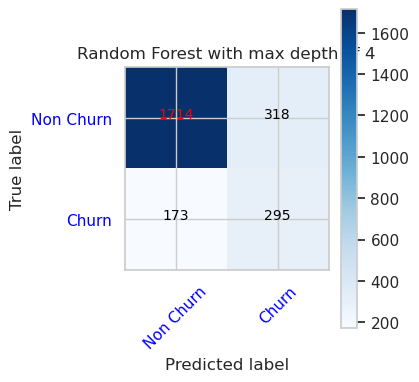

In [26]:
cfm = confusion_matrix(y_test, y_pred=ypred_rfc1_sm)
plot_confusion_matrix(cfm, classes=['Non Churn','Churn'],
                      title='Random Forest with max depth of 4')
tn, fp, fn, tp = cfm.ravel()

Create a confusion matrix for Random Forest Classifier with maximum depth of eight, with six features.

StatementMeta(, a4f4b4b4-a1ed-4a09-a7f4-3c7ee851591b, 36, Finished, Available, Finished)

[[1809  223]
 [ 182  286]]


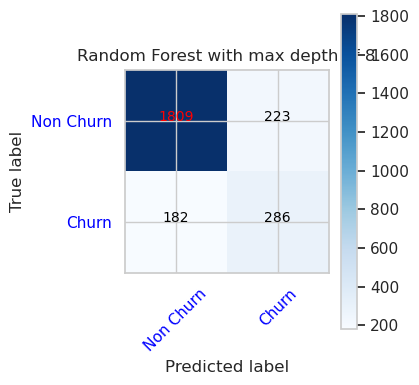

In [27]:
cfm = confusion_matrix(y_test, y_pred=ypred_rfc2_sm)
plot_confusion_matrix(cfm, classes=['Non Churn','Churn'],
                      title='Random Forest with max depth of 8')
tn, fp, fn, tp = cfm.ravel()

Create the confusion matrix for LightGBM.

StatementMeta(, a4f4b4b4-a1ed-4a09-a7f4-3c7ee851591b, 37, Finished, Available, Finished)

[[1881  151]
 [ 198  270]]


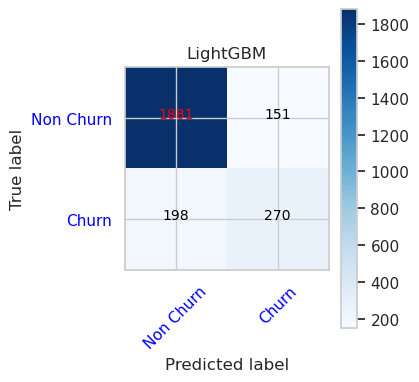

In [28]:
cfm = confusion_matrix(y_test, y_pred=ypred_lgbm1_sm)
plot_confusion_matrix(cfm, classes=['Non Churn','Churn'],
                      title='LightGBM')
tn, fp, fn, tp = cfm.ravel()

### Save the predicted results for insights visualization in Power BI

In [29]:
spark.conf.set("spark.sql.parquet.vorder.enabled", "true") # Enable VOrder write
spark.conf.set("spark.microsoft.delta.optimizeWrite.enabled", "true") # Enable automatic delta optimized write

StatementMeta(, a4f4b4b4-a1ed-4a09-a7f4-3c7ee851591b, 38, Finished, Available, Finished)

In [30]:
df_pred = X_test.copy()
df_pred['y_test'] = y_test
df_pred['ypred_rfc1_sm'] = ypred_rfc1_sm
df_pred['ypred_rfc2_sm'] = ypred_rfc2_sm
df_pred['ypred_lgbm1_sm'] = ypred_lgbm1_sm

table_name = "churn_pred"
sparkDF=spark.createDataFrame(df_pred)
sparkDF.write.mode("overwrite").format("delta").option("overwriteSchema", "true").save(f"Tables/{table_name}")
print(f"Spark dataframe saved to delta table: {table_name}")

StatementMeta(, a4f4b4b4-a1ed-4a09-a7f4-3c7ee851591b, 39, Finished, Available, Finished)

Spark dataframe saved to delta table: churn_pred


## [OPTIONAL] PREDICT with the Transformer API

Alternatively, you can model scoring using PREDICT (with Transformer API). Microsoft Fabric allows users to operationalize machine learning models with a scalable function called PREDICT, which supports batch scoring in any compute engine. Users can generate batch predictions directly from a Microsoft Fabric notebook or from a given model's item page. For more details, read: https://learn.microsoft.com/en-us/fabric/data-science/model-scoring-predict 

To use the Transformer API from SynapseML, you'll need to first create an MLFlowTransformer object.

#### Instantiate MLFlowTransformer object
The MLFlowTransformer object is a wrapper around the MLFlow model that you registered in Part 3. It allows you to generate batch predictions on a given DataFrame. To instantiate the MLFlowTransformer object, you'll need to provide the following parameters:

The columns from the test DataFrame that you need as input to the model (in this case, you would need all of them).
A name for the new output column (in this case, predictions).
The correct model name and model version to generate the predictions (in this case, lgbm_sm and version 1).

Finally, you can use the MLFlowTransformer object to generate batch predictions.


In [31]:
df_test = spark.read.format("delta").load("Tables/churn_test")
display(df_test)

StatementMeta(, a4f4b4b4-a1ed-4a09-a7f4-3c7ee851591b, 40, Finished, Available, Finished)

SynapseWidget(Synapse.DataFrame, 2899a282-709c-47fc-958e-fd83f9ba190f)

In [33]:
from synapse.ml.predict import MLFlowTransformer

# You can substitute values below for your own input columns,
# output column name, model name, and model version
model = MLFlowTransformer(
    inputCols=df_test.columns,
    outputCol='predictions',
    modelName='lgbm_sm_demo',
    modelVersion=1
)

StatementMeta(, a4f4b4b4-a1ed-4a09-a7f4-3c7ee851591b, 42, Finished, Available, Finished)

/opt/spark/python/lib/pyspark.zip/pyspark/sql/pandas/functions.py:407: UserWarning: In Python 3.6+ and Spark 3.0+, it is preferred to specify type hints for pandas UDF instead of specifying pandas UDF type which will be deprecated in the future releases. See SPARK-28264 for more details.


StatementMeta(, a4f4b4b4-a1ed-4a09-a7f4-3c7ee851591b, 43, Finished, Available, Finished)

In [34]:
import pandas

predictions = model.transform(df_test)
display(predictions)

StatementMeta(, a4f4b4b4-a1ed-4a09-a7f4-3c7ee851591b, 44, Finished, Available, Finished)

SynapseWidget(Synapse.DataFrame, 763bda37-03f1-4365-b110-a48d15560124)

In [35]:
# Save above predictions for lgbm_sm to lakehouse to be used for generating a Power BI report
table_name = "churn_pred_lgbm"
predictions.write.format('delta').mode("overwrite").save(f"Tables/{table_name}")
print(f"Spark DataFrame saved to delta table: {table_name}")

StatementMeta(, a4f4b4b4-a1ed-4a09-a7f4-3c7ee851591b, 45, Finished, Available, Finished)

Spark DataFrame saved to delta table: churn_pred_lgbm
